## Step 1: Configuración del entorno y carga de datos ##### 
- Se importan las librerías necesarias para análisis de datos, visualización y machine learning.
- Se definen las variables de configuración para acceder a Google Cloud Storage.
- Se implementa una función genérica para leer archivos CSV directamente desde GCS.
- Se crean funciones específicas para cargar los datos de entrenamiento y prueba.
- Se asegura que todas las fuentes de datos provengan de un único origen controlado.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from google.cloud import storage
import pandas as pd
import io

BUCKET_NAME = "4geeks-ds-lab-data"
DATA_FOLDER = "predicting-poverty"


def read_csv_from_gcs(bucket_name, file_path):
    """Read a CSV file stored in Google Cloud Storage and return a pandas DataFrame."""
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(file_path)

    data = blob.download_as_bytes()
    return pd.read_csv(io.BytesIO(data))

def load_train_values():
    return read_csv_from_gcs(
        BUCKET_NAME,
        f"{DATA_FOLDER}/train_values_wJZrCmI.csv"
    )

def load_train_labels():
    return read_csv_from_gcs(
        BUCKET_NAME,
        f"{DATA_FOLDER}/train_labels.csv"
    )

def load_test_values():
    return read_csv_from_gcs(
        BUCKET_NAME,
        f"{DATA_FOLDER}/test_values.csv"
    )

## Step 2: Carga de datasets y verificación inicial #####
- Se cargan los datos de entrenamiento desde Google Cloud Storage.
- Se cargan las etiquetas asociadas al conjunto de entrenamiento.
- Se cargan los datos de prueba para futuras predicciones.
- Se utiliza `.head()` para inspeccionar la estructura de los datasets.
- Se valida que los datos se hayan cargado correctamente.


In [56]:
train_values = load_train_values()
train_labels = load_train_labels()
test_values  = load_test_values()

train_values.head(), train_labels.head(), test_values.head()

(   row_id country  is_urban   age  female  married religion  \
 0       0       C     False  18.0    True     True        P   
 1       1       C      True  30.0    True     True        P   
 2       2       A     False  20.0    True     True        Q   
 3       3       A     False  61.0   False     True        Q   
 4       4       D     False  26.0    True     True        X   
 
   relationship_to_hh_head  education_level  literacy  ...  \
 0                   Other              1.0      True  ...   
 1                   Other              1.0      True  ...   
 2                  Spouse              1.0      True  ...   
 3                    Head              0.0     False  ...   
 4                  Spouse              1.0      True  ...   
 
    reg_formal_nbfi_account  financially_included  active_bank_user  \
 0                    False                  True              True   
 1                    False                  True              True   
 2                    False

## Step 3: Carga y verificación de los datos de entrenamiento #####
- Se cargan nuevamente los valores de entrenamiento desde la fuente definida.
- Se mantiene comentada la carga local como referencia o alternativa.
- Se prioriza el uso de datos centralizados desde Google Cloud Storage.
- Se visualiza el contenido del dataset para confirmar su correcta carga.
- Se refuerza la trazabilidad y consistencia del flujo de datos.


In [57]:
#train_labels = pd.read_csv(r"train_labels.csv")
#train_labels

train_values = load_train_values()
train_values

,row_id,country,is_urban,age,female,married,religion,relationship_to_hh_head,education_level,literacy,...,reg_formal_nbfi_account,financially_included,active_bank_user,active_mm_user,active_formal_nbfi_user,active_informal_nbfi_user,nonreg_active_mm_user,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year
0,0,C,False,18.0,True,True,P,Other,1.0,True,...,False,True,True,False,False,False,False,1,0,1
1,1,C,True,30.0,True,True,P,Other,1.0,True,...,False,True,True,False,False,False,False,1,0,0
2,2,A,False,20.0,True,True,Q,Spouse,1.0,True,...,False,False,False,False,False,False,False,0,0,0
3,3,A,False,61.0,False,True,Q,Head,0.0,False,...,False,False,False,False,False,False,False,0,0,0
4,4,D,False,26.0,True,True,X,Spouse,1.0,True,...,False,False,False,False,False,False,False,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12595,12595,C,True,50.0,False,True,P,Head,1.0,True,...,False,True,False,False,False,False,False,2,0,1
12596,12596,D,False,90.0,False,False,O,Head,0.0,True,...,False,False,False,False,False,False,False,0,0,0
12597,12597,J,False,52.0,True,False,X,Head,1.0,False,...,False,True,False,False,False,True,False,0,1,0
12598,12598,I,False,40.0,False,True,Q,Head,0.0,False,...,False,False,False,False,False,False,False,0,0,0


## Step 4 — Carga y verificación de las etiquetas de entrenamiento

- Se mantiene comentada la opción de carga local de las etiquetas como referencia.
- Se cargan las etiquetas de entrenamiento usando la función definida previamente.
- Se asegura que las etiquetas provengan de la misma fuente centralizada.
- Se visualiza el contenido de las etiquetas para confirmar su correcta carga.
- Se valida que las etiquetas estén alineadas con los datos de entrenamiento.


In [58]:
# train_labels = pd.read_csv(r"train_labels.csv")
# train_labels
train_labels = load_train_labels()
train_labels

,row_id,poverty_probability
0,0,0.515
1,1,0.981
2,2,0.982
3,3,0.879
4,4,0.796
...,...,...
12595,12595,0.990
12596,12596,0.950
12597,12597,0.342
12598,12598,0.846



## Step 5 — Integración de features y etiquetas

- Se combinan los datos de entrenamiento con sus etiquetas correspondientes.
- Se utiliza la columna `row_id` como clave de unión entre ambos datasets.
- Se aplica un `left join` para conservar todos los registros de entrenamiento.
- Se garantiza que cada fila de datos tenga asociada su etiqueta.
- Se construye el dataset final que será usado para el entrenamiento del modelo.

In [59]:
train = train_values.merge(train_labels, on="row_id", how="left")

## Step 6 — Verificación del dataset final de entrenamiento

- Se visualiza el dataset de entrenamiento ya integrado.
- Se confirma que los valores y etiquetas estén correctamente combinados.

In [60]:
train

,row_id,country,is_urban,age,female,married,religion,relationship_to_hh_head,education_level,literacy,...,financially_included,active_bank_user,active_mm_user,active_formal_nbfi_user,active_informal_nbfi_user,nonreg_active_mm_user,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year,poverty_probability
0,0,C,False,18.0,True,True,P,Other,1.0,True,...,True,True,False,False,False,False,1,0,1,0.515
1,1,C,True,30.0,True,True,P,Other,1.0,True,...,True,True,False,False,False,False,1,0,0,0.981
2,2,A,False,20.0,True,True,Q,Spouse,1.0,True,...,False,False,False,False,False,False,0,0,0,0.982
3,3,A,False,61.0,False,True,Q,Head,0.0,False,...,False,False,False,False,False,False,0,0,0,0.879
4,4,D,False,26.0,True,True,X,Spouse,1.0,True,...,False,False,False,False,False,False,1,0,3,0.796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12595,12595,C,True,50.0,False,True,P,Head,1.0,True,...,True,False,False,False,False,False,2,0,1,0.990
12596,12596,D,False,90.0,False,False,O,Head,0.0,True,...,False,False,False,False,False,False,0,0,0,0.950
12597,12597,J,False,52.0,True,False,X,Head,1.0,False,...,True,False,False,False,True,False,0,1,0,0.342
12598,12598,I,False,40.0,False,True,Q,Head,0.0,False,...,False,False,False,False,False,False,0,0,0,0.846


## Step 7 — Carga y verificación de los datos de prueba

- Se mantiene comentada la opción de carga local de los datos de prueba.
- Se cargan los datos de prueba desde la fuente centralizada definida.
- Se prioriza el uso de Google Cloud Storage como origen de datos.
- Se visualiza el dataset de prueba para confirmar su correcta carga.
- Se valida que la estructura sea compatible con los datos de entrenamiento.


In [61]:
#test = pd.read_csv(r"test_values.csv")
# test

test = load_test_values()
test

,row_id,country,is_urban,age,female,married,religion,relationship_to_hh_head,education_level,literacy,...,reg_formal_nbfi_account,financially_included,active_bank_user,active_mm_user,active_formal_nbfi_user,active_informal_nbfi_user,nonreg_active_mm_user,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year
0,0,F,False,57.0,True,True,X,Father/Mother,3.0,True,...,False,False,False,False,False,False,False,0,0,0
1,1,C,False,40.0,False,True,P,Head,0.0,True,...,False,True,False,False,False,False,False,0,0,0
2,2,I,False,35.0,True,True,Q,Spouse,1.0,False,...,False,False,False,False,False,True,True,1,1,2
3,3,I,True,19.0,True,False,Q,Son/Daughter,3.0,True,...,False,False,False,False,False,True,False,0,1,0
4,4,A,False,61.0,True,True,Q,Father/Mother,0.0,False,...,False,False,False,False,False,False,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,8395,G,True,63.0,False,True,X,Head,1.0,True,...,True,True,True,True,True,True,False,3,2,5
8396,8396,J,False,59.0,False,False,X,Father/Mother,1.0,False,...,False,False,False,False,False,False,False,0,0,0
8397,8397,A,False,21.0,True,True,Q,Spouse,1.0,False,...,False,False,False,False,False,False,True,1,0,1
8398,8398,F,True,32.0,False,True,X,Head,3.0,True,...,False,True,True,False,False,False,False,1,0,3


## Step 8 — Limpieza de columnas no necesarias

- Se elimina la columna `row_id` del dataset de entrenamiento.
- Se descarta información que solo cumple función identificadora.
- Se evita que columnas irrelevantes entren al modelo.
- Se mantiene únicamente la información útil para el entrenamiento.
- Se prepara el dataset para el preprocesamiento y modelado.

In [62]:
#se elimina una de las 2 columnas objetivo y row_id
train = train.drop(columns=['row_id'])

## Step 9 — Limpieza de columnas no necesarias en datos de prueba

- Se elimina la columna `row_id` del dataset de prueba.
- Se descarta un identificador que no aporta valor predictivo.
- Se asegura coherencia estructural con el dataset de entrenamiento.
- Se evita introducir columnas irrelevantes en las predicciones.
- Se prepara el dataset de prueba para el preprocesamiento.


In [63]:
test = test.drop(columns=['row_id'], axis=1)

## Step 10 — Verificación visual de los datos de prueba

- Se visualiza el dataset de prueba después de la limpieza.
- Se confirma que la columna `row_id` fue eliminada correctamente.
- Se valida la estructura final del conjunto de prueba.
- Se verifica que no existan columnas inesperadas.
- Se asegura que el dataset esté listo para el preprocesamiento y predicción.


In [64]:
test

,country,is_urban,age,female,married,religion,relationship_to_hh_head,education_level,literacy,can_add,...,reg_formal_nbfi_account,financially_included,active_bank_user,active_mm_user,active_formal_nbfi_user,active_informal_nbfi_user,nonreg_active_mm_user,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year
0,F,False,57.0,True,True,X,Father/Mother,3.0,True,True,...,False,False,False,False,False,False,False,0,0,0
1,C,False,40.0,False,True,P,Head,0.0,True,True,...,False,True,False,False,False,False,False,0,0,0
2,I,False,35.0,True,True,Q,Spouse,1.0,False,True,...,False,False,False,False,False,True,True,1,1,2
3,I,True,19.0,True,False,Q,Son/Daughter,3.0,True,True,...,False,False,False,False,False,True,False,0,1,0
4,A,False,61.0,True,True,Q,Father/Mother,0.0,False,False,...,False,False,False,False,False,False,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8395,G,True,63.0,False,True,X,Head,1.0,True,True,...,True,True,True,True,True,True,False,3,2,5
8396,J,False,59.0,False,False,X,Father/Mother,1.0,False,True,...,False,False,False,False,False,False,False,0,0,0
8397,A,False,21.0,True,True,Q,Spouse,1.0,False,True,...,False,False,False,False,False,False,True,1,0,1
8398,F,True,32.0,False,True,X,Head,3.0,True,True,...,False,True,True,False,False,False,False,1,0,3


## Step 11 — Exploración de valores únicos de la variable país

- Se extraen los valores únicos de la columna `country`.
- Se aplica una operación de agregación sobre dichos valores.
- Se realiza una verificación rápida del contenido de la variable país.
- Se valida que los datos tengan consistencia antes del preprocesamiento.
- Se identifica posibles anomalías en la codificación de la variable.


In [65]:
train_values['country'].unique().sum()

'CADGFIJ'

## Step 12 — Separación de variables predictoras y variable objetivo

- Se define explícitamente la columna objetivo del modelo.
- Se separan las variables predictoras (`X_train`) de la variable objetivo (`y_train`).
- Se elimina la variable objetivo del conjunto de entrenamiento.
- Se prepara el conjunto de prueba sin incluir la variable objetivo.
- Se deja la estructura lista para el preprocesamiento y entrenamiento del modelo.

In [66]:
#separar X de y
target_column = "poverty_probability"  
X_train = train.drop(target_column, axis=1)
y_train = train[target_column]
X_test = test.copy()

## Step 13 — Identificación y agrupación de tipos de variables

- Se identifican las columnas booleanas del conjunto de entrenamiento.
- Se identifican las columnas numéricas continuas.
- Se identifican las columnas categóricas.
- Se detectan columnas binarias codificadas como 0 y 1.
- Se reclasifican las columnas binarias como booleanas para su correcto tratamiento.


In [67]:
#agrupar por tipo de columnas
bool_cols = X_train.select_dtypes(include=['bool']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Detectar columnas binarias 0/1 como booleanas
binary_cols = [c for c in num_cols if X_train[c].dropna().isin([0,1]).all()]
num_cols = [c for c in num_cols if c not in binary_cols]
bool_cols = bool_cols + binary_cols

## Step 14 — Inspección de la estructura del conjunto de entrenamiento

- Se imprime información general del dataset de entrenamiento.
- Se revisan los tipos de datos de cada columna.
- Se identifica la cantidad de valores no nulos por variable.
- Se detectan posibles valores faltantes.
- Se obtiene una visión global antes del preprocesamiento.

In [68]:
print("Información general:")
print(X_train.info())

Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Data columns (total 58 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   country                                12600 non-null  object 
 1   is_urban                               12600 non-null  bool   
 2   age                                    12600 non-null  float64
 3   female                                 12600 non-null  bool   
 4   married                                12600 non-null  bool   
 5   religion                               12600 non-null  object 
 6   relationship_to_hh_head                12600 non-null  object 
 7   education_level                        12364 non-null  float64
 8   literacy                               12600 non-null  bool   
 9   can_add                                12600 non-null  bool   
 10  can_divide                             12600 non-

## Step 15 — Análisis estadístico descriptivo de las variables numéricas

- Se calculan estadísticas descriptivas básicas de las variables numéricas.
- Se analizan medidas como media, desviación estándar y percentiles.
- Se identifican posibles valores atípicos o rangos inesperados.
- Se valida la escala y distribución de las variables.
- Se obtiene contexto previo al preprocesamiento y modelado.

In [69]:
print("\nEstadísticas descriptivas:")
print(X_train.describe())


Estadísticas descriptivas:
                age  education_level  share_hh_income_provided  \
count  12600.000000     12364.000000              12295.000000   
mean      36.280714         1.316241                  2.888166   
std       15.145945         0.905442                  1.564284   
min       15.000000         0.000000                  1.000000   
25%       25.000000         1.000000                  1.000000   
50%       33.000000         1.000000                  2.000000   
75%       45.000000         2.000000                  5.000000   
max      115.000000         3.000000                  5.000000   

       num_times_borrowed_last_year  borrowing_recency  bank_interest_rate  \
count                  12600.000000       12600.000000          289.000000   
mean                       0.657698           0.866429            9.843080   
std                        0.924598           0.960866           15.033089   
min                        0.000000           0.000000           

## Step 16 — Detección de valores faltantes en el conjunto de entrenamiento

- Se calcula la cantidad de valores faltantes por columna.
- Se identifican variables con datos incompletos.
- Se evalúa la magnitud del problema de valores nulos.
- Se obtiene información clave para definir estrategias de imputación.
- Se prepara el dataset para el preprocesamiento adecuado.

In [70]:
print("\nValores faltantes por columna:")
print(X_train.isnull().sum())


Valores faltantes por columna:
country                                      0
is_urban                                     0
age                                          0
female                                       0
married                                      0
religion                                     0
relationship_to_hh_head                      0
education_level                            236
literacy                                     0
can_add                                      0
can_divide                                   0
can_calc_percents                            0
can_calc_compounding                         0
employed_last_year                           0
employment_category_last_year                0
employment_type_last_year                    0
share_hh_income_provided                   305
income_ag_livestock_last_year                0
income_friends_family_last_year              0
income_government_last_year                  0
income_own_business_last_yea

## Step 17 — Visualización de la distribución de variables numéricas

- Se generan histogramas para cada variable numérica.
- Se utiliza estimación de densidad (KDE) para observar la forma de la distribución.
- Se identifican posibles asimetrías y valores atípicos.
- Se evalúa si las variables requieren transformaciones.
- Se obtiene contexto visual previo al preprocesamiento.

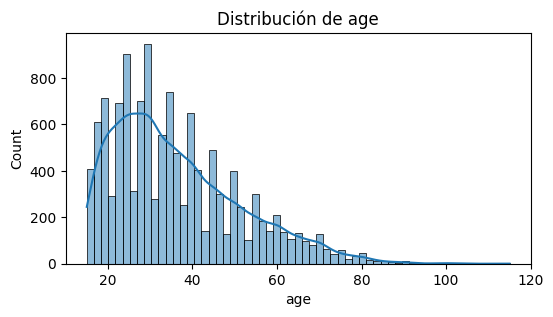

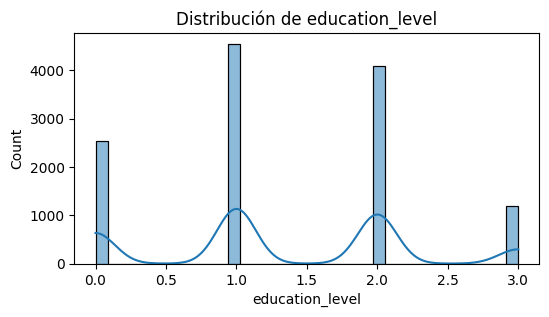

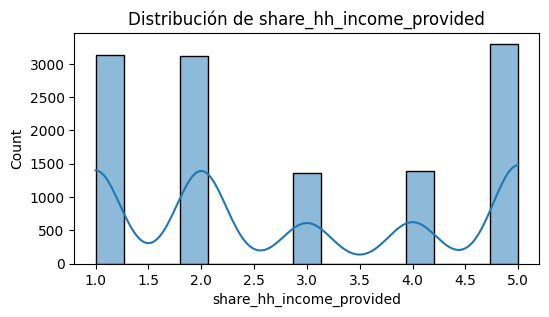

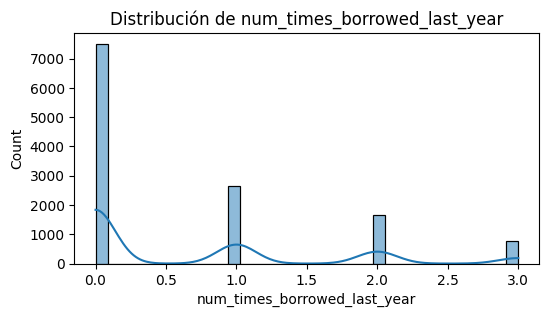

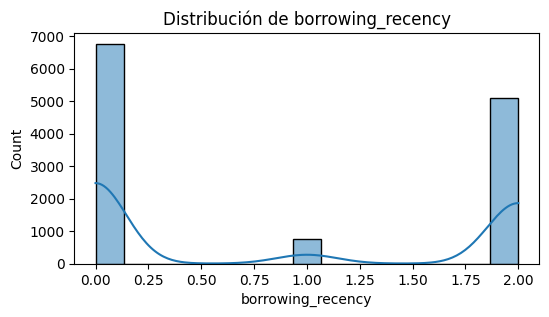

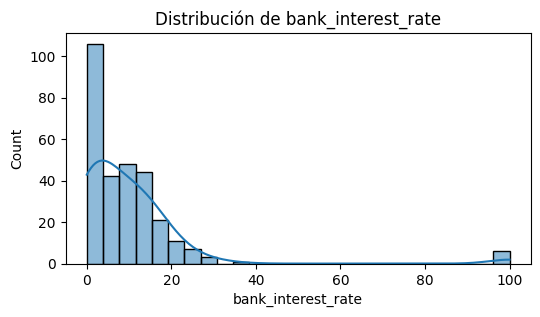

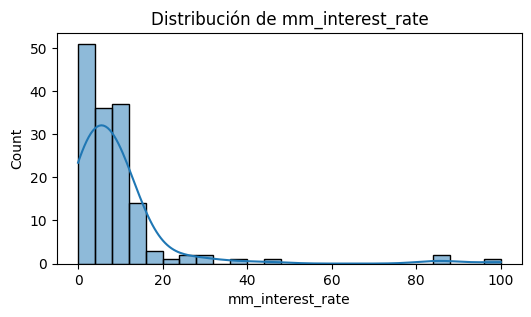

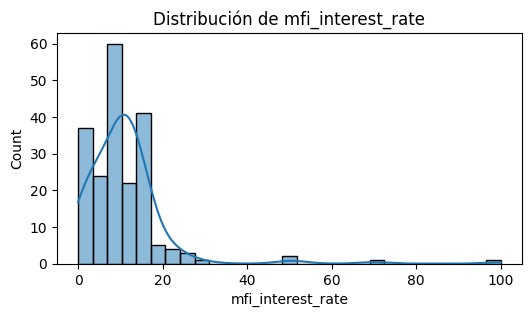

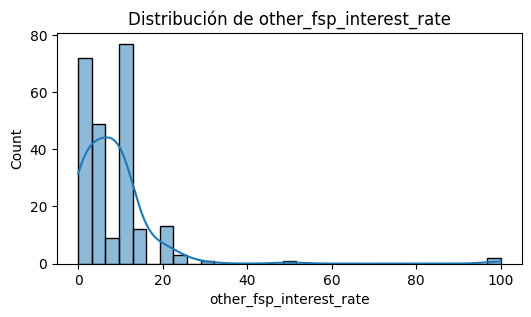

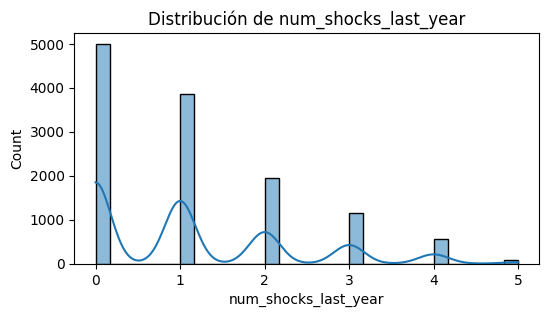

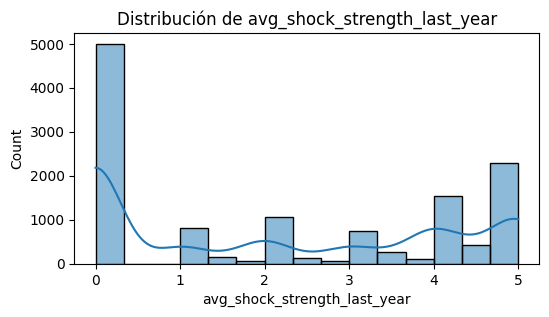

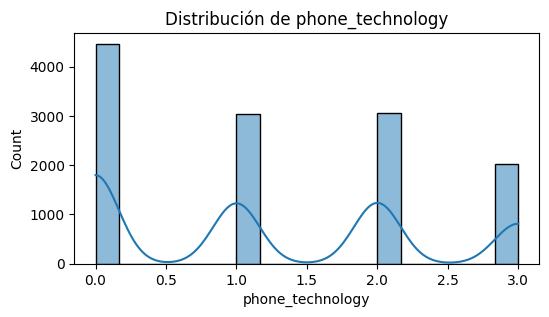

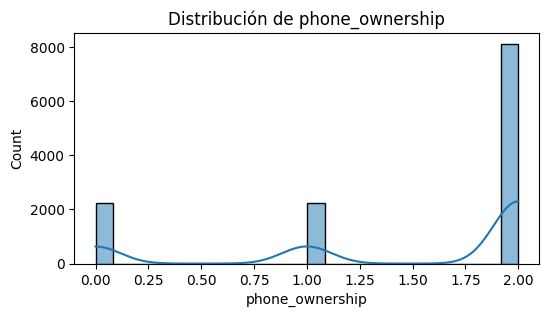

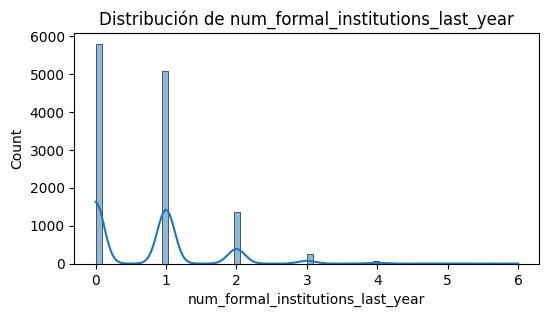

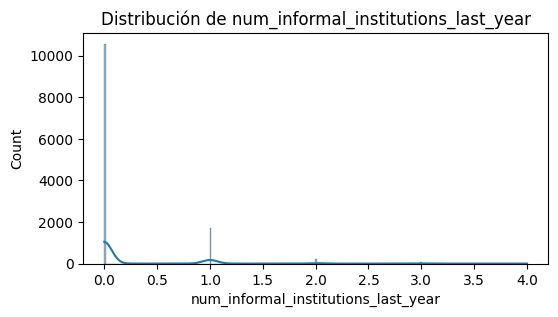

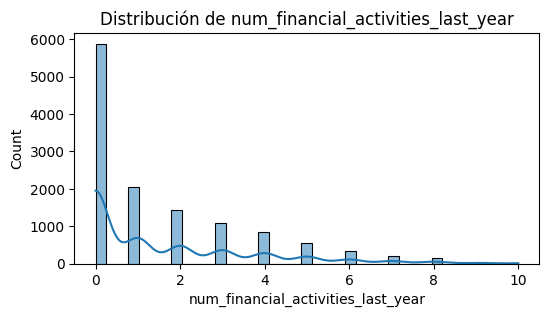

In [71]:
#distribucion de variables numericas 
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(X_train[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.show()

## Step 18 — Análisis de correlación con la variable objetivo

- Se combinan las variables numéricas con la variable objetivo.
- Se calcula la matriz de correlación entre las variables.
- Se visualiza la correlación mediante un mapa de calor.
- Se identifican variables con mayor relación con la variable objetivo.
- Se obtiene información para interpretar y entender el comportamiento del modelo.

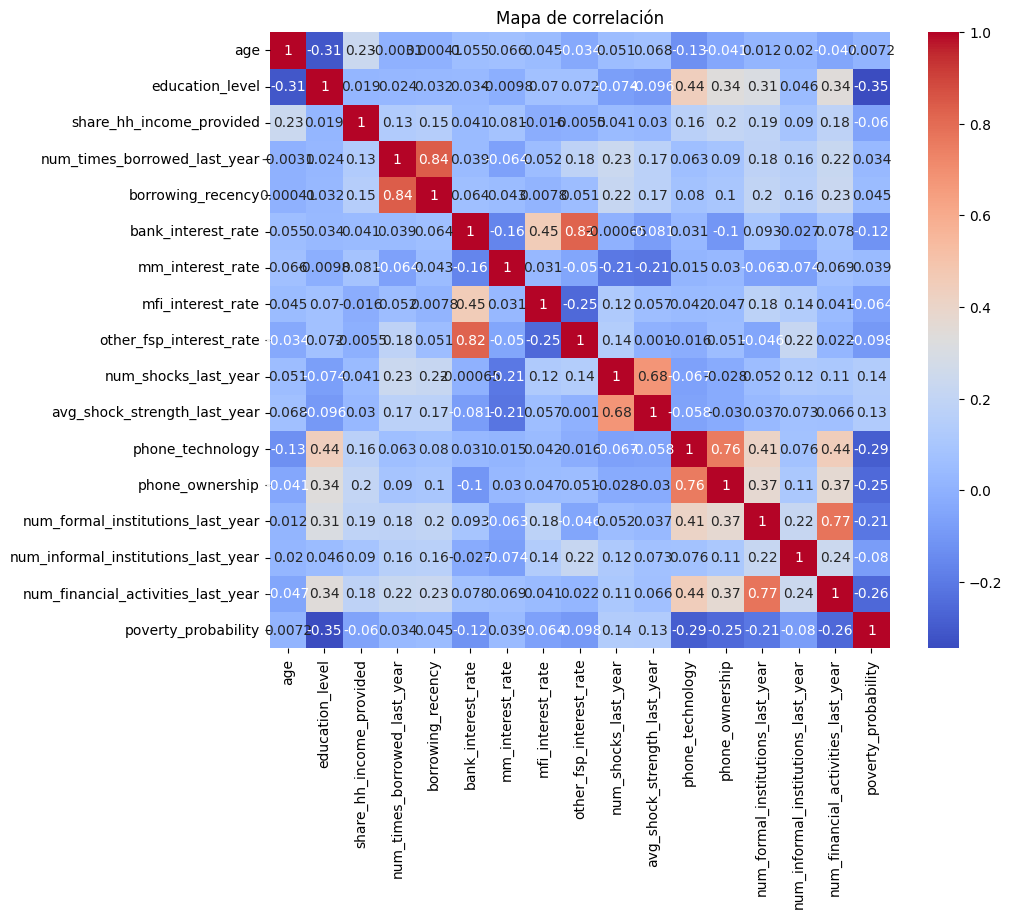

In [72]:
#correlacion con la variable objetivo
correlation = pd.concat([X_train[num_cols], y_train], axis=1).corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Mapa de correlación")
plt.show()

## Step 19 — Análisis de cardinalidad de variables categóricas

- Se analiza la cantidad de categorías únicas por variable categórica.
- Se identifica la cardinalidad de cada columna.
- Se detectan variables con alta cantidad de categorías.
- Se evalúa el impacto potencial en el preprocesamiento.
- Se obtiene información para definir estrategias de codificación.

In [73]:

#cantidad de categorias por columna 
for col in cat_cols:
    print(f'{col}: {X_train[col].nunique()} categorías')

country: 7 categorías
religion: 5 categorías
relationship_to_hh_head: 7 categorías
employment_category_last_year: 5 categorías
employment_type_last_year: 5 categorías


## Step 20 — Definición del preprocesamiento de variables

- Se define un transformador que aplica preprocesamiento según el tipo de variable.
- Las variables numéricas se estandarizan usando `StandardScaler`.
- Las variables categóricas se codifican mediante One-Hot Encoding.
- Las variables booleanas se mantienen sin transformación.
- Todo el preprocesamiento queda centralizado en un único objeto reutilizable.


In [74]:
#preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("bool", "passthrough", bool_cols)
    ]
)

## Step 21 — Conversión de variables booleanas a formato numérico

- Se recorren todas las columnas booleanas identificadas previamente.
- Se convierten los valores booleanos a enteros (0 y 1).
- Se aplica la conversión tanto al conjunto de entrenamiento como al de prueba.
- Se asegura compatibilidad con los modelos de machine learning.
- Se evita inconsistencias durante el preprocesamiento y entrenamiento.


In [75]:
for col in bool_cols:
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)

## Step 22— Limpieza y normalización de columnas numéricas

- Se recorren todas las columnas numéricas identificadas.
- Se convierten los valores a string para limpieza previa.
- Se eliminan caracteres no deseados como corchetes.
- Se convierten los valores finales al tipo numérico `float`.
- Se aplica el mismo tratamiento a entrenamiento y prueba.

In [76]:
# Para columnas numéricas
for col in num_cols:
    # Elimina corchetes y convierte a float
    X_train[col] = X_train[col].astype(str).str.replace(r"[\[\]]", "", regex=True).astype(float)
    X_test[col] = X_test[col].astype(str).str.replace(r"[\[\]]", "", regex=True).astype(float)

## Step 23 — Verificación del tipo de datos de variables booleanas

- Se inspeccionan los tipos de datos de las columnas booleanas.
- Se confirma que las variables estén en formato numérico.
- Se valida que la conversión a enteros fue exitosa.
- Se detectan posibles inconsistencias de tipo antes del pipeline.
- Se asegura compatibilidad con el preprocesamiento y el modelo.


In [77]:
print(X_train[bool_cols].dtypes)

is_urban                                 int64
female                                   int64
married                                  int64
literacy                                 int64
can_add                                  int64
can_divide                               int64
can_calc_percents                        int64
can_calc_compounding                     int64
employed_last_year                       int64
income_ag_livestock_last_year            int64
income_friends_family_last_year          int64
income_government_last_year              int64
income_own_business_last_year            int64
income_private_sector_last_year          int64
income_public_sector_last_year           int64
formal_savings                           int64
informal_savings                         int64
cash_property_savings                    int64
has_insurance                            int64
has_investment                           int64
borrowed_for_emergency_last_year         int64
borrowed_for_

## Step 24 — Creación del pipeline de entrenamiento con XGBoost

- Se define un modelo de regresión basado en XGBoost.
- Se configuran los hiperparámetros principales del modelo.
- Se establece una semilla aleatoria para reproducibilidad.
- Se integra el preprocesamiento y el modelo en un solo pipeline.
- Se garantiza consistencia entre entrenamiento y predicción.


In [78]:
#creación del pipeline
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("xgb", xgb_model)
])

## Step 25 — Entrenamiento y validación interna del modelo

- Se divide el conjunto de entrenamiento en datos de entrenamiento y validación.
- Se reserva un porcentaje de los datos para validación interna.
- Se entrena el pipeline completo usando los datos de entrenamiento.
- Se generan predicciones sobre el conjunto de validación.
- Se prepara el escenario para evaluar el desempeño del modelo.


In [79]:
#validacion interna
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
pipeline.fit(X_tr, y_tr)
y_val_pred = pipeline.predict(X_val)

## Step 26 — Evaluación del desempeño del modelo en validación

- Se calculan métricas de error sobre el conjunto de validación.
- Se obtiene el error cuadrático medio (MSE).
- Se calcula la raíz del error cuadrático medio (RMSE).
- Se evalúa el coeficiente de determinación (R²).
- Se imprimen las métricas para interpretar el desempeño del modelo.


In [80]:
#metricas sobre validación
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_val_pred)

print(f"RMSE (validación): {rmse:.4f}")
print(f"R2 Score (validación): {r2:.4f}")


RMSE (validación): 0.2159
R2 Score (validación): 0.4358


## Step 27 — Entrenamiento final del modelo con todos los datos

- Se entrena el pipeline utilizando todo el conjunto de entrenamiento.
- Se incluyen tanto los datos usados previamente en validación como los restantes.
- Se aprovecha la totalidad de la información disponible.
- Se obtiene el modelo final que será usado para predicción.
- Se deja el pipeline listo para inferencia sobre datos nuevos.


In [81]:
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Step 28 — Generación de predicciones sobre el conjunto de prueba

- Se utiliza el pipeline entrenado para generar predicciones.
- Se aplican automáticamente las mismas transformaciones de preprocesamiento.
- Se obtienen predicciones para cada registro del conjunto de prueba.
- Se produce el output final del modelo.
- Se prepara el resultado para exportación o análisis posterior.

In [82]:
test_predictions = pipeline.predict(X_test)

## Step 29— Obtención de nombres de las columnas después del preprocesamiento
* Accede al preprocesador (ColumnTransformer) que está dentro del pipeline ya entrenado.
* Obtiene los nombres de todas las variables resultantes después de aplicar el preprocesamiento.
* Genera nombres explícitos para las variables categóricas creadas por el OneHotEncoder.
* Conserva el mismo orden de las columnas transformadas que usa el modelo.
* Permite que gráficos como los de SHAP muestren los nombres reales de las variables en lugar de Feature 0, Feature 1, etc.


In [83]:
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

## Step 30— Definición de un modelo XGBoost base

- Se crea una instancia base del modelo `XGBRegressor`.
- Se define la función objetivo para regresión.
- Se fija una semilla aleatoria para reproducibilidad.
- Se habilita el uso de todos los núcleos disponibles del sistema.
- Se deja el modelo listo para pruebas o comparaciones adicionales.


In [84]:
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

## Step 31 — Creación de un pipeline alternativo con XGBoost base

- Se construye un pipeline combinando preprocesamiento y modelo.
- Se reutiliza el mismo preprocesador definido previamente.
- Se integra el modelo XGBoost base al pipeline.
- Se mantiene la consistencia en las transformaciones de datos.
- Se deja el pipeline listo para entrenamiento o comparación de resultados.


In [85]:
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb)
])

## Step 32 — Inspección técnica del resultado del preprocesamiento

- Se aplica manualmente el preprocesador al conjunto de entrenamiento.
- Se inspeccionan las primeras filas del dataset transformado.
- Se verifica el tipo del objeto resultante del preprocesamiento.
- Se valida el tipo de dato interno de la matriz transformada.
- Se utiliza como paso de depuración y entendimiento del pipeline.

In [86]:
# CODIGO YUSEFF

X_train_transformed = pipeline.named_steps["preprocessor"].transform(X_train)
print(X_train_transformed[:5])
print(type(X_train_transformed), X_train_transformed.dtype)

[[-1.20701878 -0.34928079 -1.20709709 -0.71136263 -0.90175201         nan
          nan         nan         nan -0.92448397 -1.04635879 -1.10586606
  -0.60294806  0.35474895 -0.39893864 -0.27385078  0.          1.
   0.          0.          0.          0.          0.          0.
   0.          1.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          1.          1.
   1.          1.          1.          1.          1.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          1.          1.          0.          0.
   0.          1.          0.          0.          1.          1.
   0.          0.          0.          0.        ]
 [-0.41469605 -0.34928079         nan -0.71136263 -0.90175201         nan
 

## Step 33 — Definición de la grilla de hiperparámetros optimizada

- Se define una grilla de hiperparámetros para búsqueda de modelos.
- Se documenta una grilla original más amplia que fue descartada (queda comentada).
- Se reduce el espacio de búsqueda para evitar timeouts/costos en Google Cloud.
- Se priorizan hiperparámetros con mayor impacto en el modelo.
- Se equilibra desempeño del modelo y tiempo de entrenamiento.


In [87]:
# ACA SE CUELGA - GC

#param_grid = {
#    "model__n_estimators": [200, 400, 600],
#    "model__max_depth": [3, 5, 7],
#    "model__learning_rate": [0.01, 0.05, 0.1],
#    "model__subsample": [0.8, 1.0],
#    "model__colsample_bytree": [0.8, 1.0]
#}

# Reduced param grid to avoid Cloud Run timeouts
param_grid = {
    "model__n_estimators": [200, 400],       # good stable values
    "model__max_depth": [3, 5],              # most influential depths
    "model__learning_rate": [0.05, 0.1],     # avoids extremely small lr that slows training
    "model__subsample": [0.8],               # best general value
    "model__colsample_bytree": [0.8]         # prevents overfitting and reduces training time
}

## Step 34 — Configuración de la búsqueda de hiperparámetros con GridSearch

- Se configura un proceso de búsqueda exhaustiva de hiperparámetros.
- Se utiliza el pipeline completo como estimador.
- Se define RMSE como métrica principal de evaluación.
- Se aplica validación cruzada con múltiples particiones.
- Se habilita paralelización para acelerar el proceso.


In [88]:
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=2
)


## Step 35 — Ejecución del GridSearch y selección de hiperparámetros óptimos

- Se ejecuta la búsqueda de hiperparámetros sobre todo el conjunto de entrenamiento.
- Se entrena el pipeline múltiples veces usando validación cruzada.
- Se evalúan las combinaciones usando RMSE como métrica.
- Se identifican los hiperparámetros con mejor desempeño.
- Se imprimen los mejores valores encontrados para el modelo.

In [89]:
grid.fit(X_train, y_train)

print("Mejores hiperparámetros:")
print(grid.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Mejores hiperparámetros:
{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 400, 'model__subsample': 0.8}


## Step 36 — Selección del mejor modelo entrenado

- Se extrae el mejor estimador resultante del GridSearch.
- Se selecciona el pipeline con los hiperparámetros óptimos.
- Se consolida el modelo con mejor desempeño en validación cruzada.
- Se deja el modelo listo para uso final.
- Se prepara el modelo para evaluación final o inferencia.


In [90]:
best_model = grid.best_estimator_

## Step 37 — Evaluación del mejor modelo en validación

- Se generan predicciones usando el mejor modelo seleccionado.
- Se evalúa el desempeño sobre el conjunto de validación.
- Se calcula el error cuadrático medio (MSE).
- Se imprime la métrica para análisis del rendimiento.
- Se valida la mejora obtenida tras la optimización de hiperparámetros.


In [91]:
y_pred = best_model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred)
print("MSE validación:", rmse)

MSE validación: 0.03336981318939478


## Step 38 — Cálculo del RMSE del modelo optimizado

- Se reutiliza el error cuadrático medio (MSE) calculado previamente.
- Se calcula la raíz cuadrada del MSE para obtener el RMSE.
- Se expresa el error en la misma escala de la variable objetivo.
- Se imprime el valor final del RMSE.
- Se facilita la interpretación del desempeño del modelo.


In [92]:
mse = mean_squared_error(y_val, y_pred)  
rmse = np.sqrt(mse)     
print (mse)
print(rmse)

0.03336981318939478
0.1826740627166177


## Step 39 — Cálculo del coeficiente de determinación (R²)

- Se calcula el coeficiente de determinación sobre el conjunto de validación.
- Se mide qué proporción de la variabilidad es explicada por el modelo.
- Se complementa la evaluación junto con RMSE y MSE.
- Se imprime el valor final de R² para su interpretación.
- Se obtiene una visión global del desempeño del modelo.


In [93]:
from sklearn.metrics import r2_score

r2 = r2_score(y_val, y_pred)
print("R² =", r2)

R² = 0.5959620923494212


## Step 40 — Verificación de países en el conjunto de prueba

- Se listan los países únicos presentes en el dataset de prueba.
- Se valida la cobertura geográfica de los datos de inferencia.
- Se comprueba coherencia con los países vistos en entrenamiento.
- Se detectan posibles categorías no observadas previamente.
- Se aporta contexto para interpretar las predicciones del modelo.


In [94]:
print("Countries in test:", test['country'].unique())

Countries in test: ['F' 'C' 'I' 'A' 'J' 'G' 'D']


## Step 41 — Verificación de columnas del conjunto de prueba

- Se listan todas las columnas presentes en el dataset de prueba.
- Se valida la estructura final de las variables.
- Se comprueba coherencia con el conjunto de entrenamiento.
- Se detectan posibles columnas faltantes o inesperadas.
- Se asegura que el dataset esté listo para inferencia o exportación.


In [95]:
print(test.columns)


Index(['country', 'is_urban', 'age', 'female', 'married', 'religion',
       'relationship_to_hh_head', 'education_level', 'literacy', 'can_add',
       'can_divide', 'can_calc_percents', 'can_calc_compounding',
       'employed_last_year', 'employment_category_last_year',
       'employment_type_last_year', 'share_hh_income_provided',
       'income_ag_livestock_last_year', 'income_friends_family_last_year',
       'income_government_last_year', 'income_own_business_last_year',
       'income_private_sector_last_year', 'income_public_sector_last_year',
       'num_times_borrowed_last_year', 'borrowing_recency', 'formal_savings',
       'informal_savings', 'cash_property_savings', 'has_insurance',
       'has_investment', 'bank_interest_rate', 'mm_interest_rate',
       'mfi_interest_rate', 'other_fsp_interest_rate', 'num_shocks_last_year',
       'avg_shock_strength_last_year', 'borrowed_for_emergency_last_year',
       'borrowed_for_daily_expenses_last_year',
       'borrowed_for_hom

## Step 42 — Verificación final del dataset y del entorno

- Se listan las columnas finales del conjunto de prueba.
- Se visualizan las primeras filas del dataset de prueba.
- Se valida la estructura y contenido antes de cualquier exportación.
- Se inspeccionan los archivos disponibles en el entorno de trabajo.
- Se confirma que todos los recursos necesarios estén presentes.


In [96]:
print(test.columns)
print(test.head())

import os
print(os.listdir())

Index(['country', 'is_urban', 'age', 'female', 'married', 'religion',
       'relationship_to_hh_head', 'education_level', 'literacy', 'can_add',
       'can_divide', 'can_calc_percents', 'can_calc_compounding',
       'employed_last_year', 'employment_category_last_year',
       'employment_type_last_year', 'share_hh_income_provided',
       'income_ag_livestock_last_year', 'income_friends_family_last_year',
       'income_government_last_year', 'income_own_business_last_year',
       'income_private_sector_last_year', 'income_public_sector_last_year',
       'num_times_borrowed_last_year', 'borrowing_recency', 'formal_savings',
       'informal_savings', 'cash_property_savings', 'has_insurance',
       'has_investment', 'bank_interest_rate', 'mm_interest_rate',
       'mfi_interest_rate', 'other_fsp_interest_rate', 'num_shocks_last_year',
       'avg_shock_strength_last_year', 'borrowed_for_emergency_last_year',
       'borrowed_for_daily_expenses_last_year',
       'borrowed_for_hom

## Step 43 — Instalación de SHAP para interpretabilidad del modelo

- Se instala la librería SHAP en el entorno de ejecución.
- Se habilita el análisis de contribución de variables del modelo.
- Se prepara el entorno para explicar predicciones del modelo.
- Se complementa el desempeño del modelo con interpretabilidad.
- Se avanza hacia un enfoque más transparente y explicable.


In [97]:
!pip install shap

## Step 44 — Instalación explícita de SHAP con pip

- Se instala la librería SHAP usando el módulo pip de Python.
- Se asegura la instalación en el entorno activo del notebook.
- Se evita conflictos con versiones de Python o kernels.
- Se garantiza disponibilidad de SHAP para los pasos siguientes.
- Se deja el entorno listo para análisis de interpretabilidad.

In [98]:
!python -m pip install shap


## Step 45 — Importación de la librería SHAP

- Se importa la librería SHAP en el entorno de trabajo.
- Se habilitan herramientas para interpretar el modelo entrenado.
- Se prepara el entorno para generar explicaciones y visualizaciones.
- Se valida que la instalación se realizó correctamente.
- Se inicia la fase de interpretabilidad del modelo.


In [99]:
import shap

## Step 46 — Interpretabilidad del modelo con SHAP (modo seguro)

- Se extrae el modelo XGBoost desde el pipeline entrenado.
- Se utiliza una muestra pequeña de los datos para evitar problemas de rendimiento.
- Se aplica el preprocesamiento antes de calcular los valores SHAP.
- Se usa `TreeExplainer`, optimizado para modelos basados en árboles.
- Se genera un gráfico resumen para interpretar la contribución de las variables.

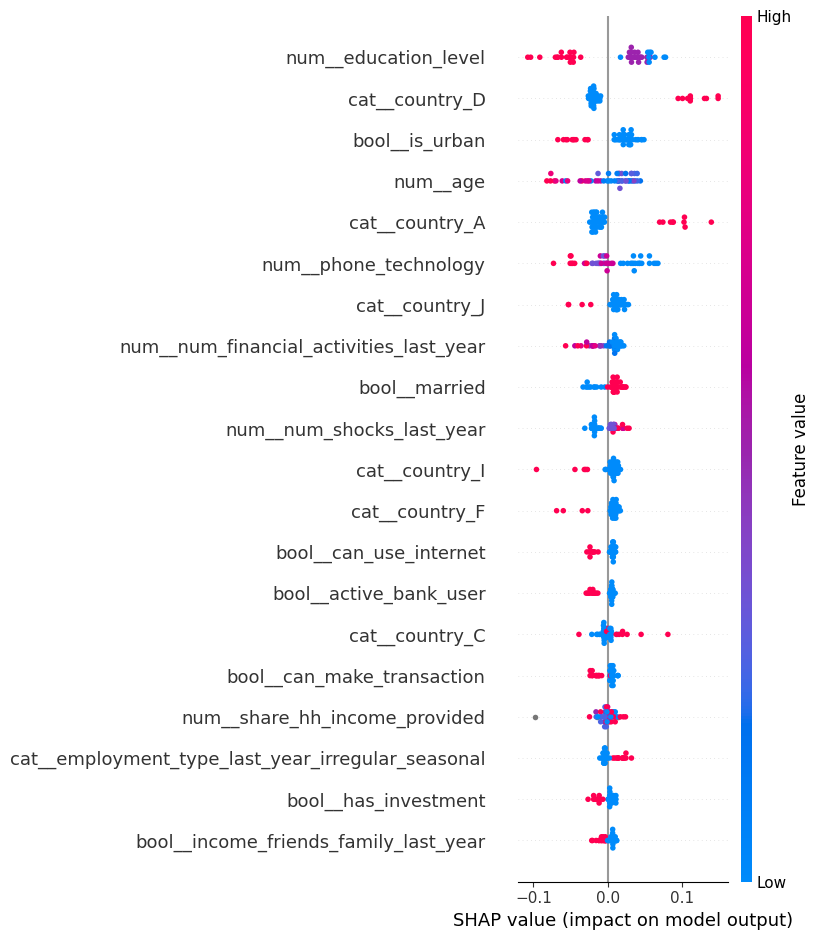

In [100]:

# 1. Extraer modelo XGBoost
# model_xgb = pipeline.named_steps["xgb"]

# 2. Usar SHAP Explainer genérico (no TreeExplainer)
#explainer = shap.Explainer(model_xgb.predict, pipeline.named_steps["preprocessor"].transform(X_train))

# 3. Obtener SHAP values
#shap_values = explainer(pipeline.named_steps["preprocessor"].transform(X_train))

# 4. Resumen gráfico
#shap.summary_plot(shap_values.values, pipeline.named_steps["preprocessor"].transform(X_train))

#import shap
#model_xgb = pipeline.named_steps["xgb"]
# EXTREME SAFE MODE
#X_shap = pipeline.named_steps["preprocessor"].transform(X_train[:50])
#explainer = shap.TreeExplainer(model_xgb)
#shap_values = explainer.shap_values(X_shap)
#shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display=10)

# 1. Extraer el modelo XGBoost
model_xgb = pipeline.named_steps["xgb"]

# 2. Extraer preprocesador 
preprocessor = pipeline.named_steps["preprocessor"]

# 3. Transformar una muestra pequeña (cloud-safe)
X_shap = preprocessor.transform(X_train[:50])

# 4. Obtener nombres reales de las variables
feature_names = preprocessor.get_feature_names_out()

# 5. TreeExplainer (ideal para XGBoost)
explainer = shap.TreeExplainer(model_xgb)

# 6. Calcular SHAP values
shap_values = explainer.shap_values(X_shap)

# 7. Summary plot con nombres reales
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=feature_names
)


## Step 47 — Interpretación del gráfico resumen de SHAP

- El gráfico SHAP muestra la importancia global de las variables del modelo.
- Cada punto representa el impacto de una variable en una predicción.
- Los valores en rojo indican valores altos de la variable.
- Los valores en azul indican valores bajos de la variable.
- La posición horizontal muestra si la variable incrementa o reduce la predicción.

In [101]:
"""
“The SHAP summary plot shows both global feature importance and the direction of impact. 
Red values indicate high feature values, blue values indicate low values, and the horizontal position shows how each feature pushes the prediction up or down.”
"""

'\n“The SHAP summary plot shows both global feature importance and the direction of impact. \nRed values indicate high feature values, blue values indicate low values, and the horizontal position shows how each feature pushes the prediction up or down.”\n'

## Step 48 — Listado final de columnas del conjunto de prueba

- Se obtiene la lista completa de columnas del dataset de prueba.
- Se verifica el orden y la presencia de todas las variables esperadas.
- Se valida la coherencia estructural antes de exportar resultados.
- Se detectan posibles columnas faltantes o adicionales.
- Se confirma que el dataset está listo para uso final.


In [102]:
print(test.columns.tolist())


['country', 'is_urban', 'age', 'female', 'married', 'religion', 'relationship_to_hh_head', 'education_level', 'literacy', 'can_add', 'can_divide', 'can_calc_percents', 'can_calc_compounding', 'employed_last_year', 'employment_category_last_year', 'employment_type_last_year', 'share_hh_income_provided', 'income_ag_livestock_last_year', 'income_friends_family_last_year', 'income_government_last_year', 'income_own_business_last_year', 'income_private_sector_last_year', 'income_public_sector_last_year', 'num_times_borrowed_last_year', 'borrowing_recency', 'formal_savings', 'informal_savings', 'cash_property_savings', 'has_insurance', 'has_investment', 'bank_interest_rate', 'mm_interest_rate', 'mfi_interest_rate', 'other_fsp_interest_rate', 'num_shocks_last_year', 'avg_shock_strength_last_year', 'borrowed_for_emergency_last_year', 'borrowed_for_daily_expenses_last_year', 'borrowed_for_home_or_biz_last_year', 'phone_technology', 'can_call', 'can_text', 'can_use_internet', 'can_make_transacti

## Step 49 — Preparación de variables categóricas
49.1.
- Se definen explícitamente las columnas categóricas relevantes.
- Se convierten las columnas a tipo `category`.
- Se prepara el dataset para usar categóricos nativos en XGBoost.
- Se evita el uso de One-Hot Encoding para estas variables.
- Se mejora eficiencia y capacidad de generalización del modelo.
  
49.2. Definición de variables objetivo y predictoras
- Se define explícitamente la variable objetivo del modelo.
- Se seleccionan las columnas predictoras excluyendo identificadores.
- Se construye una lista limpia de features.
- Se asegura coherencia entre entrenamiento y prueba.
- Se deja listo el dataset para modelado directo.

49.3. Entrenamiento de un modelo global
- Se divide el dataset en entrenamiento y validación.
- Se entrena un modelo XGBoost global con todos los países.
- Se habilita soporte para variables categóricas nativas.
- Se evalúa el desempeño con RMSE.
- Se obtiene una referencia base de desempeño global.

49.4. Entrenamiento de modelos específicos por país
- Se identifican todos los países presentes en el dataset.
- Se filtran los datos por país.
- Se entrena un modelo independiente por cada país.
- Se evalúa el desempeño de cada modelo con RMSE.
- Se almacenan los modelos y métricas por país.

49.5 Generación de predicciones finales por país
- Se crea un identificador interno para el conjunto de prueba.
- Se generan predicciones usando el modelo correspondiente a cada país.
- Se omiten países sin datos de prueba.
- Se consolidan todas las predicciones en un solo dataframe.
- Se ordenan los resultados para entrega final.
  

In [103]:
# 1. Convert object columns to categorical
# ==========================================================
categorical_cols = [
    'country',
    'religion',
    'relationship_to_hh_head',
    'employment_category_last_year',
    'employment_type_last_year'
]

for col in categorical_cols:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

# ==========================================================
# 2. Define target and feature columns
# ==========================================================
target_column = "poverty_probability"

# Features = all columns except id + target
feature_cols = [
    col for col in train.columns 
    if col not in ["id", target_column]
]

# ==========================================================
# 3. Train GLOBAL model
# ==========================================================
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Simple 80/20 split
split = int(len(train) * 0.8)

X = train[feature_cols]
y = train[target_column]

X_train, X_val = X.iloc[:split], X.iloc[split:]
y_train, y_val = y.iloc[:split], y.iloc[split:]

model_global = XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    enable_categorical=True  # <─ important
)

model_global.fit(X_train, y_train)

y_pred_val = model_global.predict(X_val)
rmse_global = mean_squared_error(y_val, y_pred_val) ** 0.5

print("RMSE Global:", rmse_global)

# ==========================================================
# 4. Train COUNTRY-SPECIFIC models
# ==========================================================
models_by_country = {}
rmse_by_country = {}

countries = train['country'].unique()

for c in countries:
    # Filter dataset for this country
    train_c = train[train['country'] == c].copy()
    
    X_c = train_c[feature_cols]
    y_c = train_c[target_column]
    
    # 80/20 split
    split = int(len(train_c) * 0.8)
    X_train_c, X_val_c = X_c.iloc[:split], X_c.iloc[split:]
    y_train_c, y_val_c = y_c.iloc[:split], y_c.iloc[split:]
    
    model = XGBRegressor(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        enable_categorical=True
    )
    
    model.fit(X_train_c, y_train_c)
    
    y_pred_val_c = model.predict(X_val_c)
    rmse_c = mean_squared_error(y_val_c, y_pred_val_c) ** 0.5
    
    models_by_country[c] = model
    rmse_by_country[c] = rmse_c

print("RMSE by country:", rmse_by_country)

# ==========================================================
# 5. Generate TEST predictions per country (FINAL CLEAN VERSION)
# ==========================================================

# Create ID column for test since it does not exist
test["id"] = np.arange(len(test))

preds_list = []

for c, model in models_by_country.items():
    test_c = test[test['country'] == c].copy()
    if test_c.empty:
        print(f"Skipping country {c} (no rows in test)")
        continue
    
    X_test_c = test_c[feature_cols]
    
    preds = model.predict(X_test_c)
    
    df_preds = pd.DataFrame({
        "id": test_c["id"],  # <-- this is your real ID now
        "poverty_probability": preds
    })
    
    preds_list.append(df_preds)

submission_country = pd.concat(preds_list).sort_values("id")
submission_country.head()


RMSE Global: 0.21502181830353606
RMSE by country: {'C': 0.2895289567928124, 'A': 0.1826228314762762, 'D': 0.17845440145158473, 'G': 0.16900126298804183, 'F': 0.2371185473453299, 'I': 0.24819990085917995, 'J': 0.21125383337285278}


,id,poverty_probability
0,0,0.313256
1,1,0.553993
2,2,0.390359
3,3,0.156949
4,4,0.868244


## Step 50 — Verificación de países en el conjunto de prueba

- Se listan los países únicos presentes en el dataset de prueba.
- Se valida la cobertura geográfica antes de la predicción final.
- Se comprueba coherencia con los países usados en entrenamiento.
- Se detectan países sin modelo disponible o sin datos asociados.
- Se aporta contexto para interpretar las predicciones generadas.


In [104]:
print("Countries in test:", test['country'].unique())

Countries in test: ['F', 'C', 'I', 'A', 'J', 'G', 'D']
Categories (7, object): ['A', 'C', 'D', 'F', 'G', 'I', 'J']


## Step 51 — Verificación final de columnas del conjunto de prueba

- Se listan todas las columnas presentes en el dataset de prueba.
- Se valida que las variables requeridas por los modelos estén disponibles.
- Se comprueba coherencia con las columnas usadas en entrenamiento.
- Se detectan posibles columnas faltantes o inesperadas.
- Se confirma que el dataset está listo para inferencia final y entrega.

In [105]:
print(test.columns)

Index(['country', 'is_urban', 'age', 'female', 'married', 'religion',
       'relationship_to_hh_head', 'education_level', 'literacy', 'can_add',
       'can_divide', 'can_calc_percents', 'can_calc_compounding',
       'employed_last_year', 'employment_category_last_year',
       'employment_type_last_year', 'share_hh_income_provided',
       'income_ag_livestock_last_year', 'income_friends_family_last_year',
       'income_government_last_year', 'income_own_business_last_year',
       'income_private_sector_last_year', 'income_public_sector_last_year',
       'num_times_borrowed_last_year', 'borrowing_recency', 'formal_savings',
       'informal_savings', 'cash_property_savings', 'has_insurance',
       'has_investment', 'bank_interest_rate', 'mm_interest_rate',
       'mfi_interest_rate', 'other_fsp_interest_rate', 'num_shocks_last_year',
       'avg_shock_strength_last_year', 'borrowed_for_emergency_last_year',
       'borrowed_for_daily_expenses_last_year',
       'borrowed_for_hom

## Step 52 — Exportación del archivo final de predicciones

- Se exportan las predicciones finales a un archivo CSV.
- Se guarda el archivo en el directorio de salida del proyecto.
- Se excluye el índice para cumplir con el formato de entrega.
- Se consolida el resultado final del modelo.
- Se deja el archivo listo para envío, evaluación o despliegue.


In [106]:
submission_country.to_csv("/notebooks/generated/submission_country_model_avance2.csv", index=False)

## Step 53 — Verificación de modelos disponibles en el entorno

- Se comprueba la existencia del modelo optimizado (`best_model`).
- Se verifica la disponibilidad del modelo global entrenado.
- Se valida que los modelos específicos por país estén cargados.
- Se asegura que los objetos clave existen en memoria.
- Se confirma que el entorno está listo para reutilización o exportación.

In [107]:
'best_model' in globals(), 'model_global' in globals(), 'models_by_country' in globals()

(True, True, True)

## Step 54 — Guardado del mejor modelo entrenado

- Se importa la librería `joblib` para serialización de modelos.
- Se guarda el modelo optimizado seleccionado (`best_model`).
- Se persiste el pipeline completo con preprocesamiento incluido.
- Se almacena el archivo en el directorio de salida del proyecto.
- Se deja el modelo listo para carga y uso posterior.

In [108]:
# Guardar el BEST MODEL
import joblib
joblib.dump(best_model, "/notebooks/generated/best_model_avance2.pkl")


['/notebooks/generated/best_model_avance2.pkl']

## Step 55 — Confirmación del guardado del modelo global

- Se vuelve a guardar el modelo global entrenado.
- Se asegura que el archivo de salida se genere correctamente.
- Se refuerza la persistencia del artefacto principal de referencia.
- Se mantiene consistencia en la ruta de almacenamiento.
- Se confirma disponibilidad del modelo para uso posterior.


In [109]:
# Guardar el GLOBAL MODEL
joblib.dump(model_global, "/notebooks/generated/model_global_avance2.pkl")

['/notebooks/generated/model_global_avance2.pkl']

## Step 56 — Verificación de archivos de modelos guardados

- Se listan los archivos `.pkl` en el directorio raíz de notebooks.
- Se listan los archivos `.pkl` en el directorio de salida generado.
- Se confirma la existencia de los modelos serializados.
- Se valida que los artefactos se hayan guardado correctamente.
- Se asegura que los modelos estén listos para carga o despliegue.


In [110]:
import os
[x for x in os.listdir('/notebooks') if x.endswith('.pkl')]
[x for x in os.listdir('/notebooks/generated') if x.endswith('.pkl')]

['best_model.pkl',
 'best_model_avance2.pkl',
 'model_global.pkl',
 'model_global_avance2.pkl']